In [1]:
words = open("names.txt","r").read().splitlines()

In [2]:
import torch

In [3]:
N = torch.zeros((27, 27, 27), dtype=torch.int32)
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [4]:
for w in words:
    chs = ['.', '.'] + list(w) + ['.']
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        ix3 = stoi[ch3]
        N[ix1][ix2][ix3] += 1

(np.float64(-0.5), np.float64(26.5), np.float64(26.5), np.float64(-0.5))

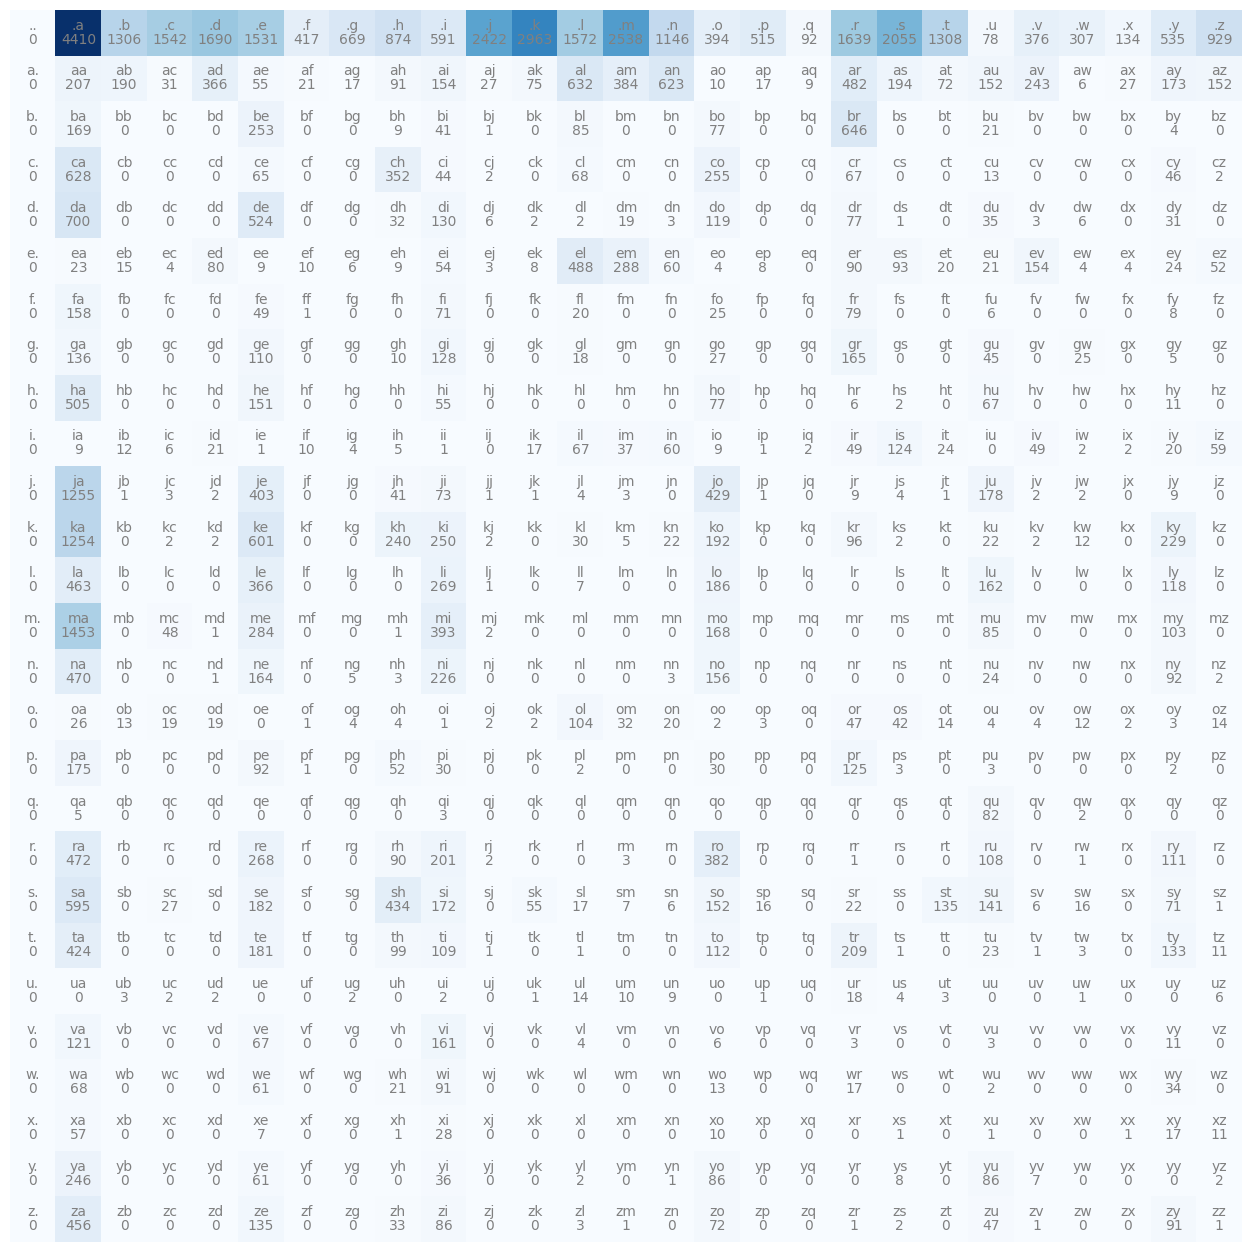

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(16,16))
plt.imshow(N[0], cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha='center', va='bottom', color='gray')
        plt.text(j, i, N[0,i,j].item(), ha='center', va='top', color='gray')
plt.axis("off")

In [6]:
p = N[0][1].float()
p = p / p.sum()
p

tensor([0.0000, 0.0469, 0.0431, 0.0070, 0.0830, 0.0125, 0.0048, 0.0039, 0.0206,
        0.0349, 0.0061, 0.0170, 0.1433, 0.0871, 0.1413, 0.0023, 0.0039, 0.0020,
        0.1093, 0.0440, 0.0163, 0.0345, 0.0551, 0.0014, 0.0061, 0.0392, 0.0345])

In [7]:
g = torch.Generator().manual_seed(2147483647)
ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
ix

4

In [8]:
P = (N + 1).float()
P = P / P.sum(2, keepdim=True)

In [9]:
g = torch.Generator().manual_seed(2147483647)

for i in range(10):
    ix1 = 0
    ix2 = 0
    out = []
    while True:
        p = P[ix1, ix2]
        ix3 = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix3])
        if ix3 == 0:
            break
        ix1, ix2 = ix2, ix3

    print(''.join(out))

ce.
bra.
jalius.
rochityharlonimittain.
luwak.
ka.
da.
samiyah.
javer.
gotai.


In [10]:
log_likelihood = 0.0
n = 0
for w in words:
    chs = ['.', '.'] + list(w) + ['.']
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        ix3 = stoi[ch3]
        prob = P[ix1][ix2][ix3]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1
print(log_likelihood)
nll = -log_likelihood
print(nll/n)

tensor(-504653.)
tensor(2.2120)


In [11]:
#create training set
xs, zs, ys = [], [], []

for w in words[:1]:
    chs = ['.', '.'] + list(w) + ['.']
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        ix3 = stoi[ch3]
        xs.append(ix1)
        zs.append(ix2)
        ys.append(ix3)

xs = torch.tensor(xs)
zs = torch.tensor(zs)
ys = torch.tensor(ys)


In [12]:
import torch.nn.functional as F
x1 = F.one_hot(xs, num_classes=27).float()
x2 = F.one_hot(zs, num_classes=27).float()
xenc = torch.cat([x1, x2], dim=1).float()

In [13]:
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((54,27), generator=g)

In [14]:
xenc.shape

torch.Size([5, 54])

In [15]:
logits = xenc @ W
counts = logits.exp()
probs = counts / counts.sum(1, keepdims=True)  #NEED TO BE CLEAR, SOFTMAX

In [16]:
#create training set
xs, zs, ys = [], [], []

for w in words:
    chs = ['.', '.'] + list(w) + ['.']
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        ix3 = stoi[ch3]
        xs.append(ix1)
        zs.append(ix2)
        ys.append(ix3)

xs = torch.tensor(xs)
zs = torch.tensor(zs)
ys = torch.tensor(ys)

num_examples = xs.size(0)
perm = torch.randperm(num_examples)

train_end = int(0.8 * num_examples)
dev_end = int(0.9 * num_examples)

train_idx = perm[:train_end]
dev_idx = perm[train_end:dev_end]
test_idx = perm[dev_end:]

xsTrain, zsTrain, ysTrain = xs[train_idx], zs[train_idx], ys[train_idx]
xsDev, zsDev, ysDev = xs[dev_idx], zs[dev_idx], ys[dev_idx]
xsTest, zsTest, ysTest = xs[test_idx], zs[test_idx], ys[test_idx]

numTrain = xsTrain.nelement()
numDev = xsDev.nelement()
numTest = xsTest.nelement()
print("num of examples: ", numTrain)

#init network
#init NN weights 27
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((54, 27), generator=g, requires_grad=True)



num of examples:  182516


In [18]:
for k in range(1000):
    #forward pass
    x1 = F.one_hot(xsTrain, num_classes=27).float()
    x2 = F.one_hot(zsTrain, num_classes=27).float()
    xenc = torch.cat([x1, x2], dim=1).float()
    logits = xenc @ W
    counts = logits.exp()
    probs = counts/ counts.sum(1, keepdim=True)
    loss = -probs[torch.arange(numTrain), ysTrain].log().mean()
    print(loss.item())

    #backward pass
    W.grad = None
    loss.backward()

    #update weights
    W.data += -10*W.grad

2.4810593128204346
2.479705572128296
2.4783759117126465
2.477069139480591
2.475785255432129
2.474522829055786
2.4732820987701416
2.472062110900879
2.47086238861084
2.4696826934814453
2.4685218334198
2.4673798084259033
2.466256856918335
2.465151071548462
2.4640631675720215
2.4629921913146973
2.461937665939331
2.460899591445923
2.4598774909973145
2.4588711261749268
2.4578793048858643
2.456902503967285
2.4559404850006104
2.4549922943115234
2.4540581703186035
2.4531373977661133
2.452230215072632
2.4513356685638428
2.450453996658325
2.4495849609375
2.44872784614563
2.4478824138641357
2.447049140930176
2.4462270736694336
2.44541597366333
2.4446160793304443
2.443826913833618
2.4430482387542725
2.442279815673828
2.441521644592285
2.4407732486724854
2.440035104751587
2.4393057823181152
2.4385862350463867
2.437875509262085
2.437174081802368
2.4364817142486572
2.435797691345215
2.43512225151062
2.434455156326294
2.4337961673736572
2.433145523071289
2.432502508163452
2.4318673610687256
2.431240081

In [21]:
g = torch.Generator().manual_seed(2147483647)

for i in range(40):
    out = []
    ix1, ix2 = 0, 0
    while True:
        x1 = F.one_hot(torch.tensor([ix1]), num_classes=27).float()
        x2 = F.one_hot(torch.tensor([ix2]), num_classes=27).float()
        xenc = torch.cat([x1, x2], dim=1).float()
        logits = xenc @ W
        counts = logits.exp()
        p = counts / counts.sum(1, keepdims=True)

        ix3 = torch.multinomial(p[0], num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix3])
        if ix3 == 0:
            break
        ix1, ix2 = ix2, ix3

    print(''.join(out))


cexze.
morlyurailaziaydamellimittain.
lusan.
ka.
da.
samiyaubrtthrigotai.
morielliausie.
teda.
kaleyla.
sade.
enkavirny.
fobspih.
ciden.
tahlasu.
jadr.
breegl.
peig.
iatta.
ra.
dinne.
zam.
der.
jair.
the.
ckayshaabsamah.
kurileelleyanimelyh.
keen.
xmal.
kalmie.
vay.
ca.
mysor.
laiten.
miengerisaifyen.
kyille.
llh.
id.
meenisammikamaxem.
keisharis.
alcalhy.


In [19]:
x1 = F.one_hot(xsDev, num_classes=27).float()
x2 = F.one_hot(zsDev, num_classes=27).float()
xenc = torch.cat([x1, x2], dim=1).float()
logits = xenc @ W
counts = logits.exp()
probs = counts/ counts.sum(1, keepdim=True)
loss = -probs[torch.arange(numDev), ysDev].log().mean()
print(loss.item())

2.3480985164642334


In [20]:
x1 = F.one_hot(xsTest, num_classes=27).float()
x2 = F.one_hot(zsTest, num_classes=27).float()
xenc = torch.cat([x1, x2], dim=1).float()
logits = xenc @ W
counts = logits.exp()
probs = counts/ counts.sum(1, keepdim=True)
loss = -probs[torch.arange(numTest), ysTest].log().mean()
print(loss.item())

2.3510935306549072


(np.float64(-0.5), np.float64(26.5), np.float64(53.5), np.float64(-0.5))

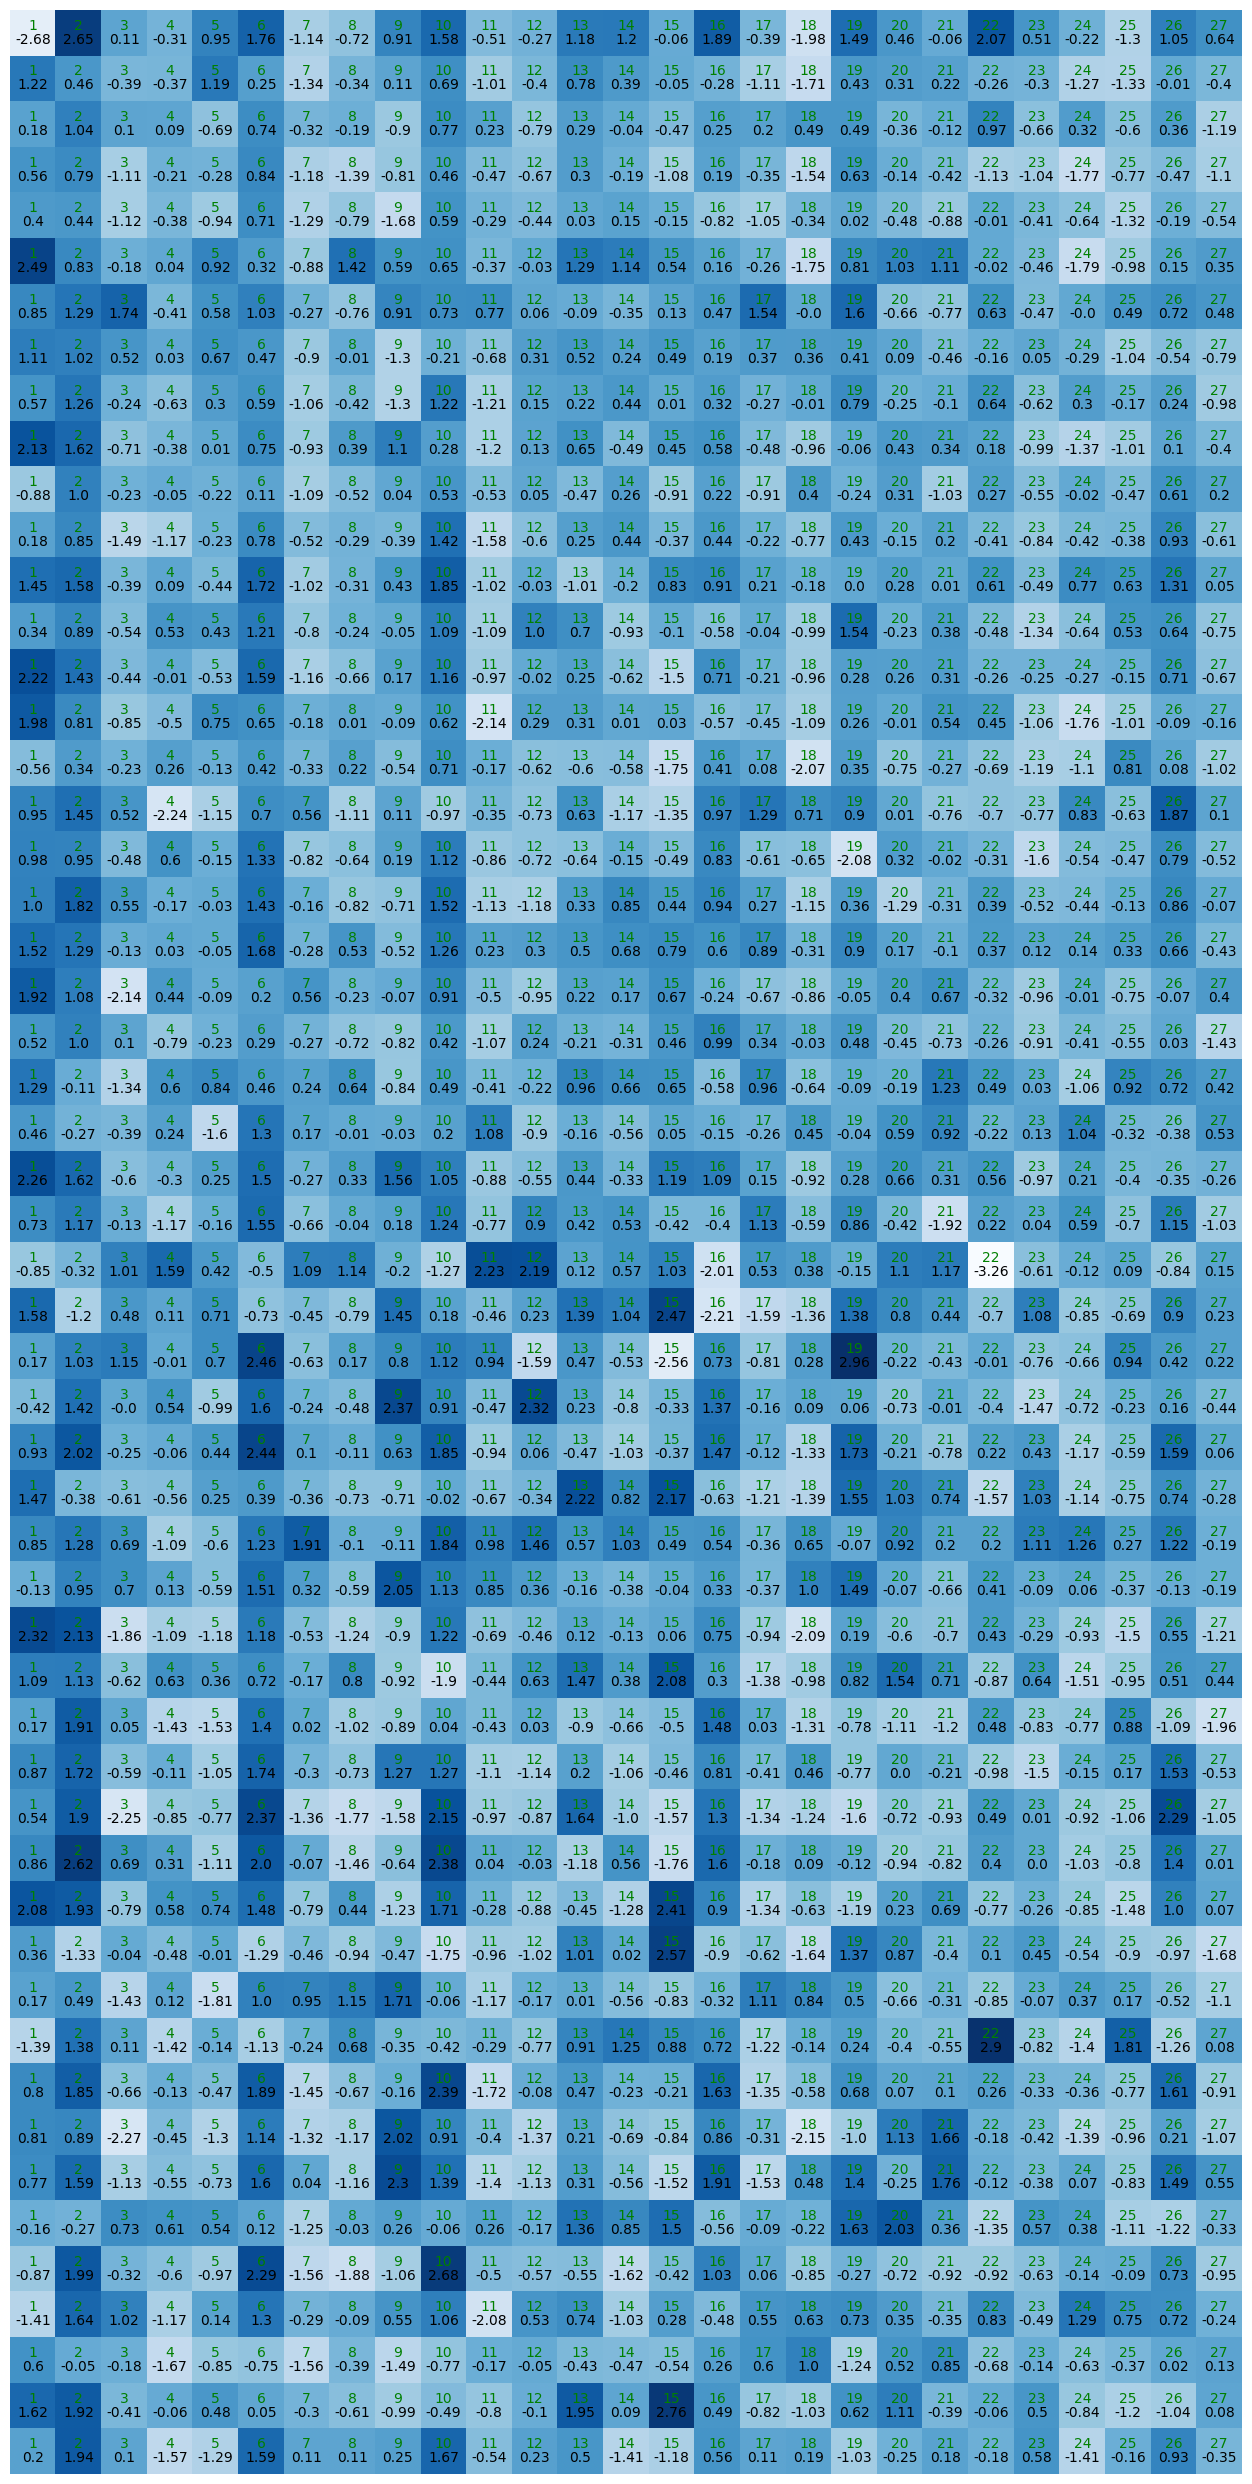

In [75]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(32,32))
plt.imshow(W.detach().numpy(), cmap='Blues')
for i in range(W.shape[0]):
    for j in range(W.shape[1]):
        plt.text(j, i, f"{j+1}", ha='center', va='bottom', color='green')
        plt.text(j, i, round(W[i,j].item(), 2), ha='center', va='top', color='black')
plt.axis("off")

In [66]:
W.shape

torch.Size([54, 27])

🎬 Генерация слова:


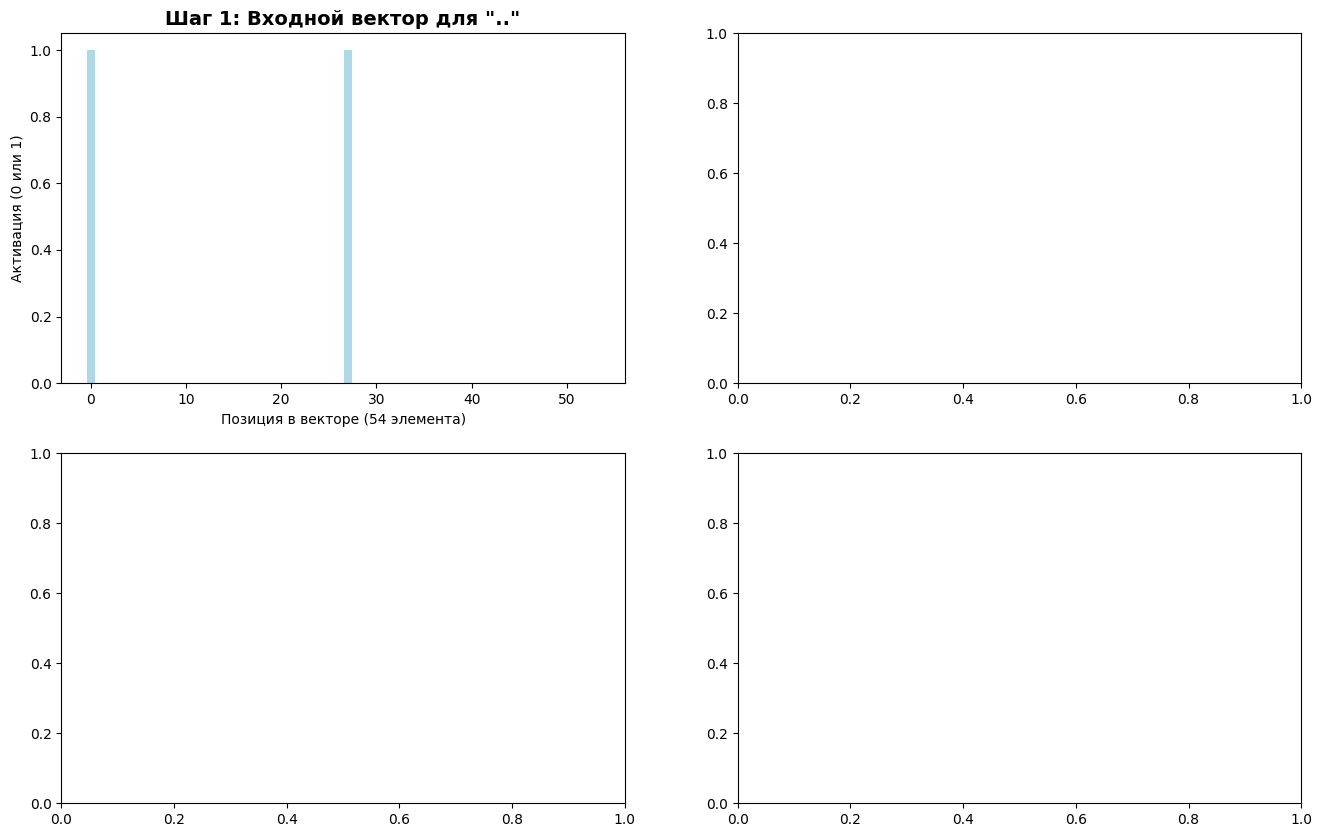

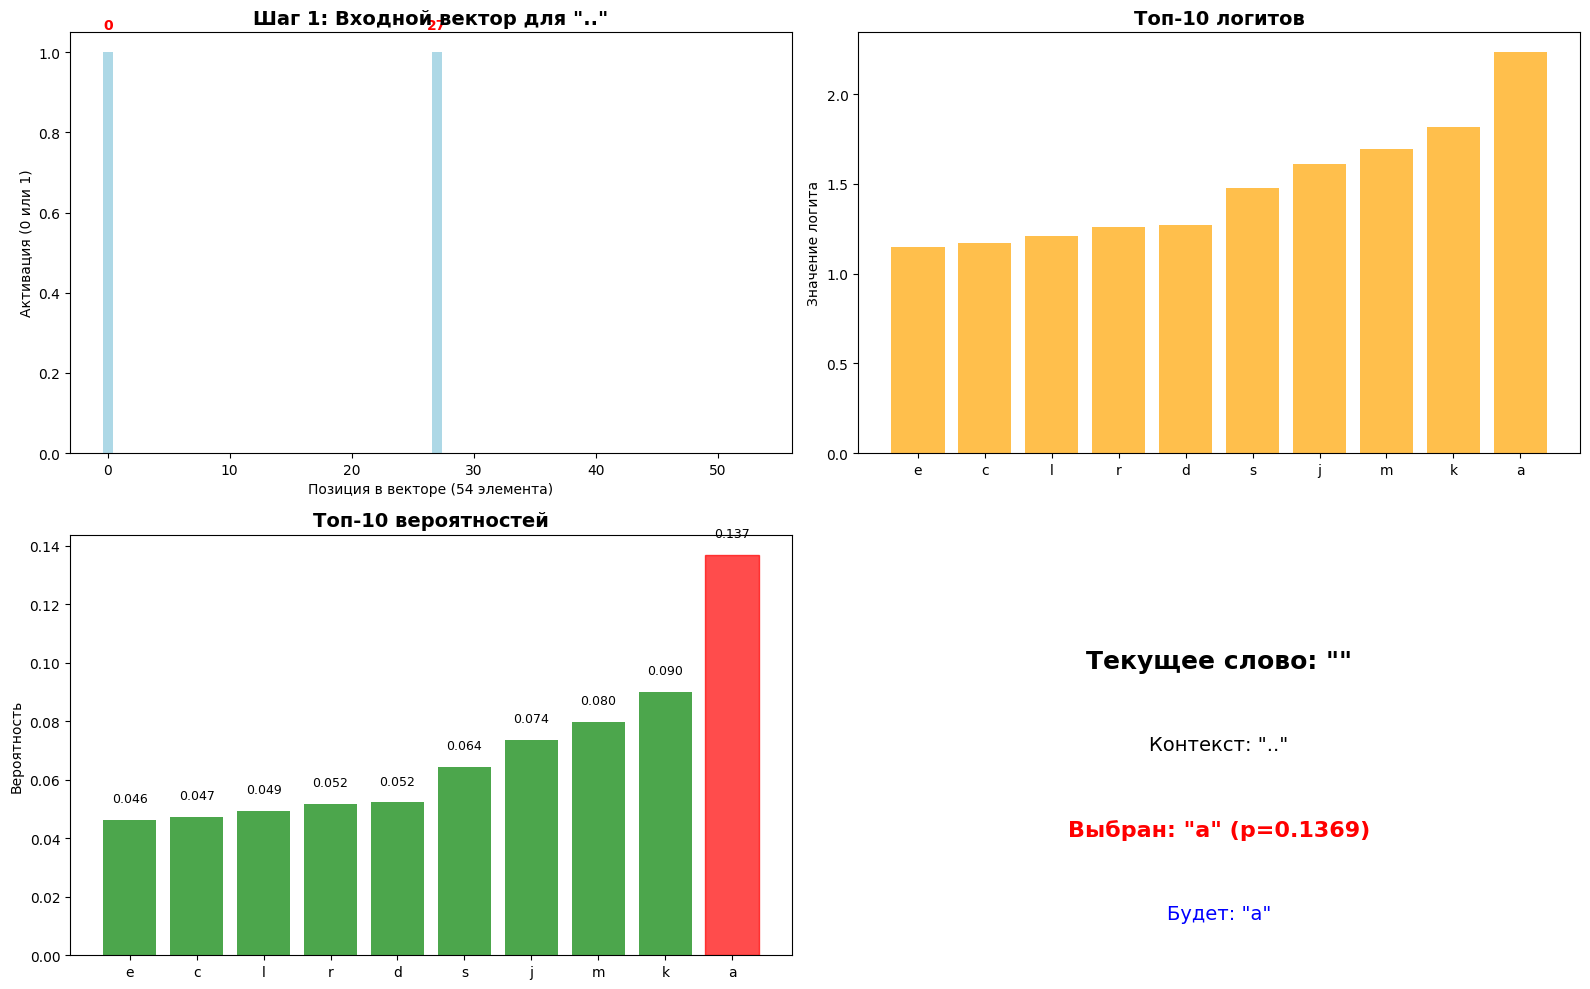


Шаг 1:
  Контекст: '..'
  Выбран: 'a' (вероятность: 0.1369)
  Слово: '' → 'a'


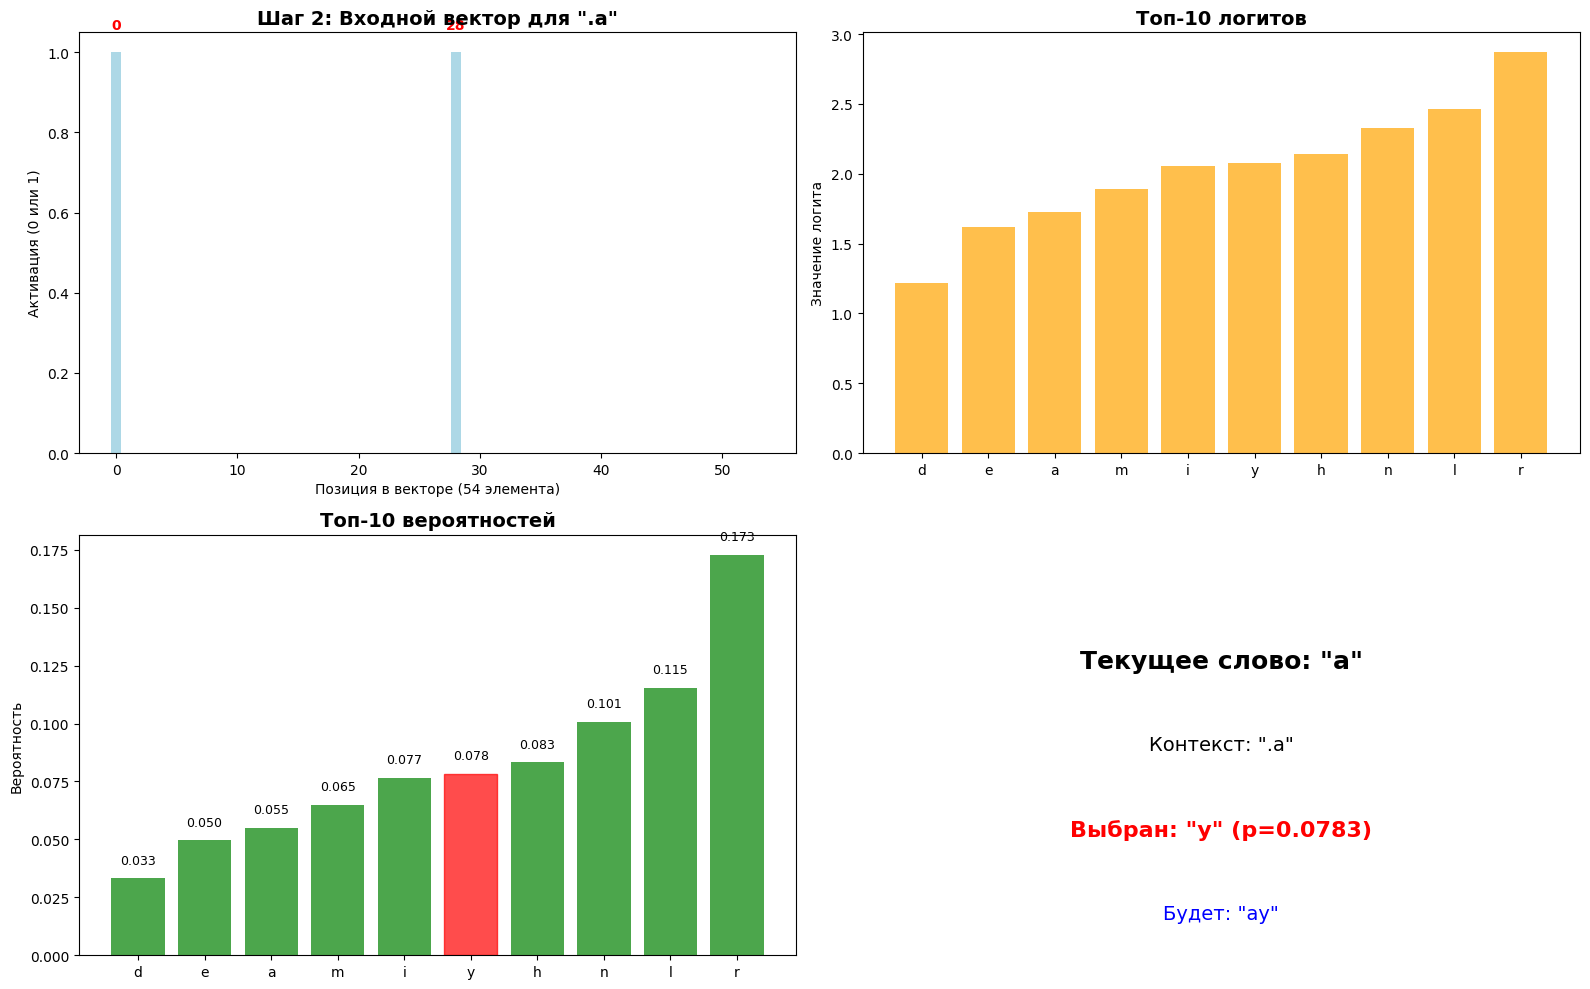


Шаг 2:
  Контекст: '.a'
  Выбран: 'y' (вероятность: 0.0783)
  Слово: 'a' → 'ay'


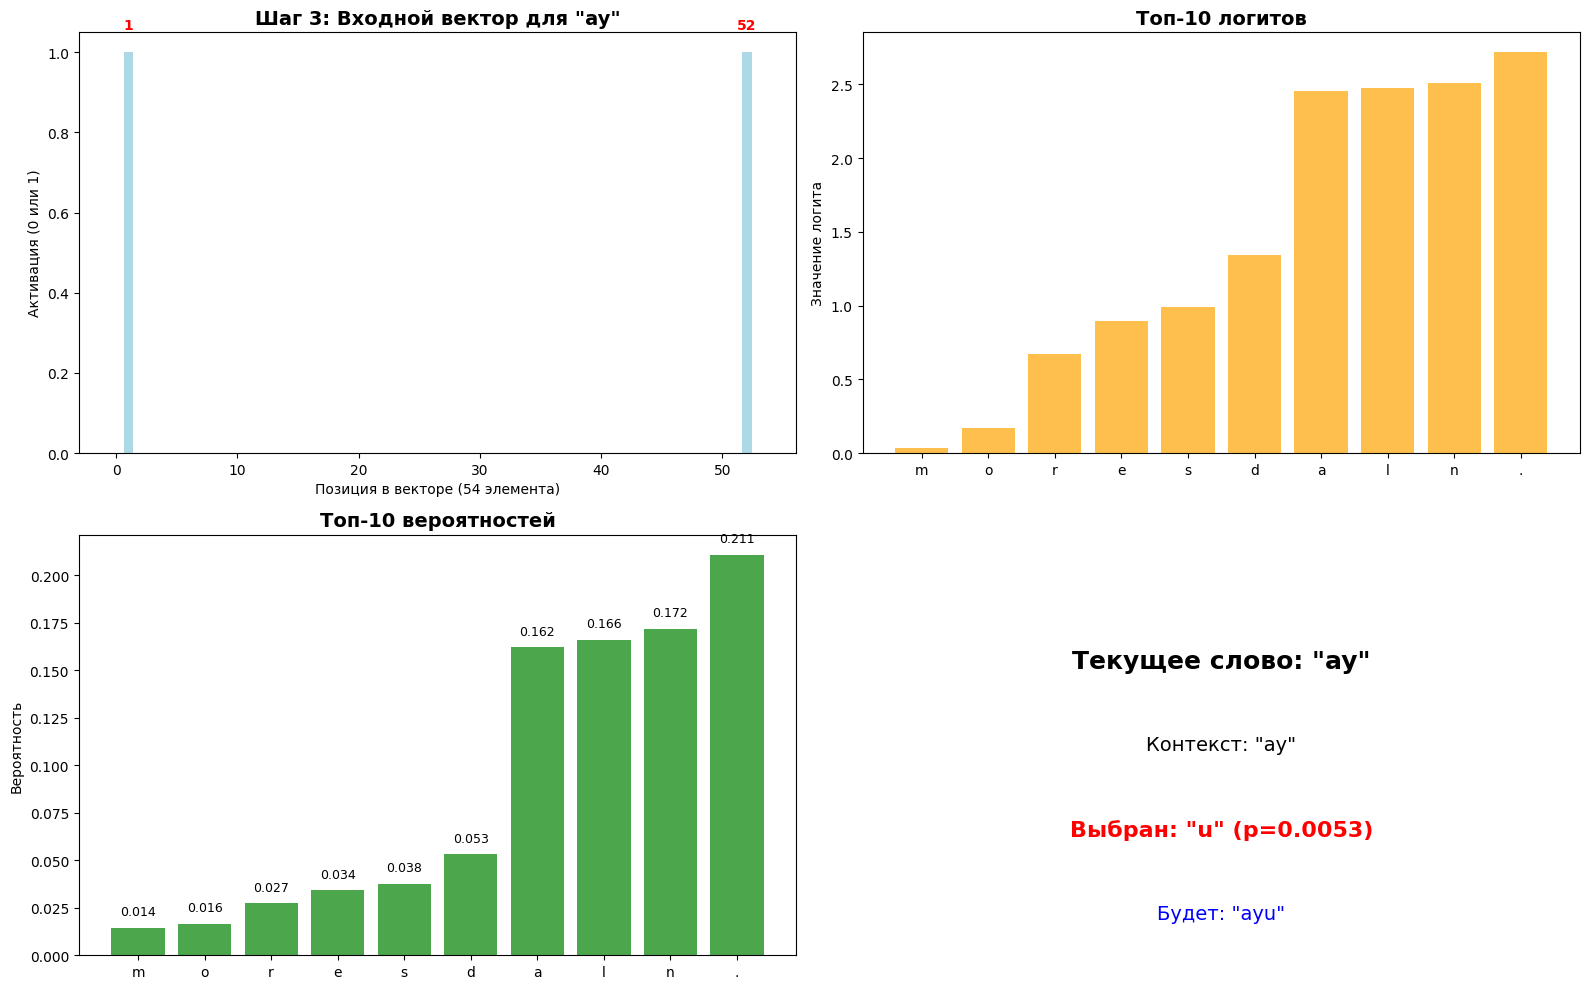


Шаг 3:
  Контекст: 'ay'
  Выбран: 'u' (вероятность: 0.0053)
  Слово: 'ay' → 'ayu'


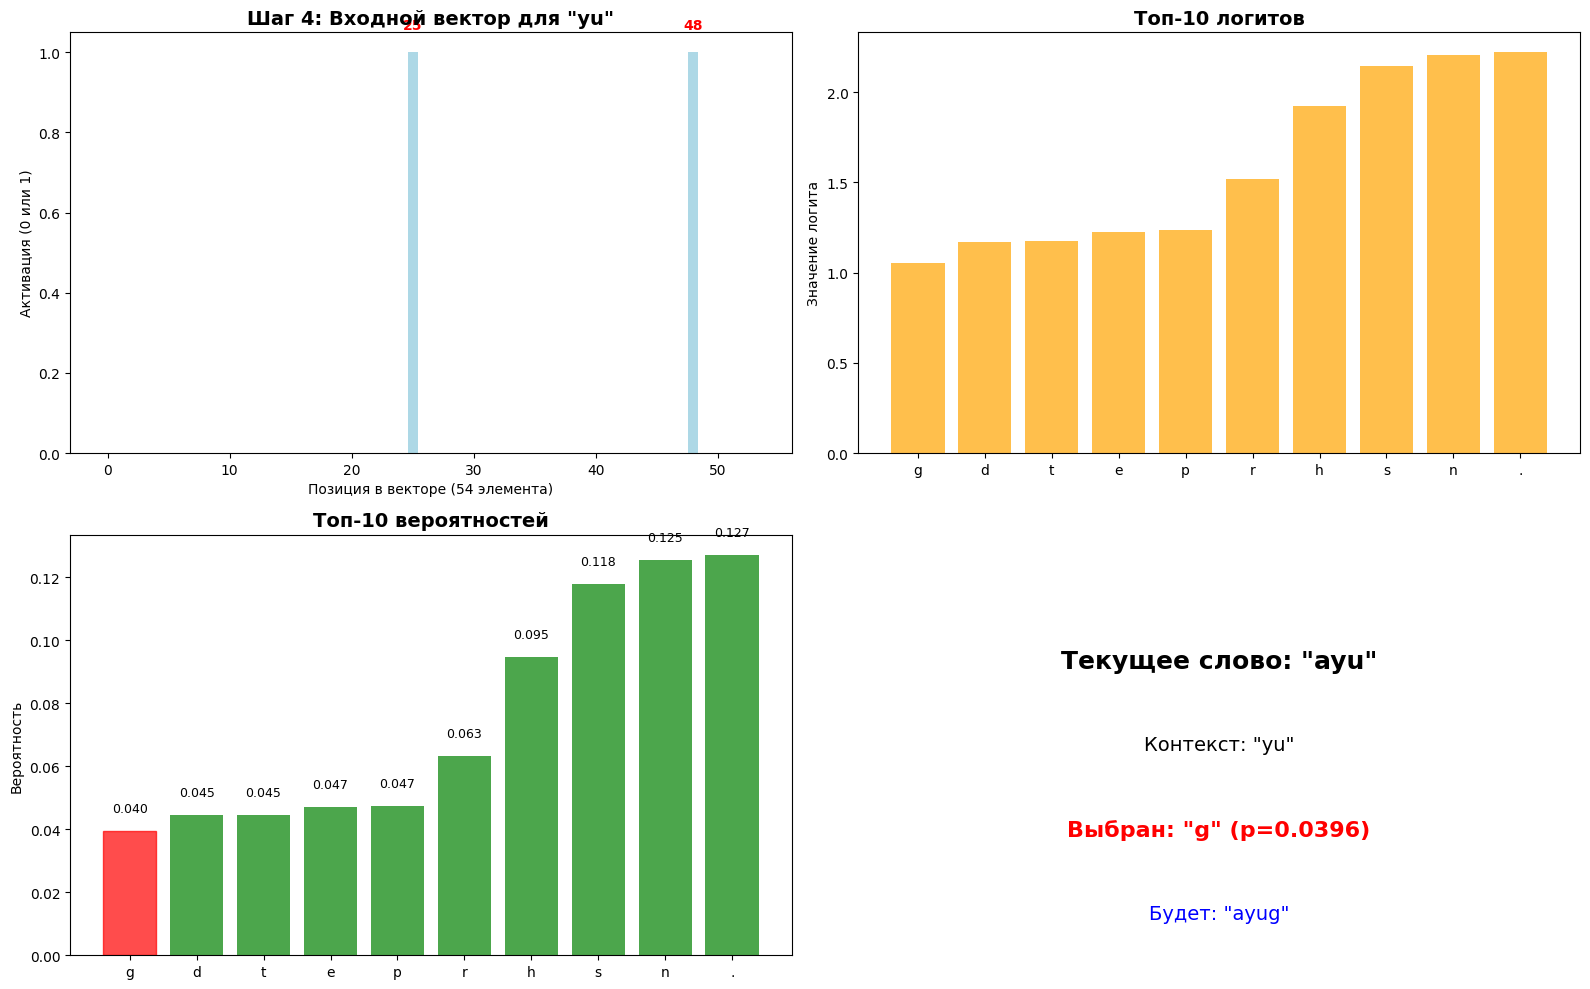


Шаг 4:
  Контекст: 'yu'
  Выбран: 'g' (вероятность: 0.0396)
  Слово: 'ayu' → 'ayug'


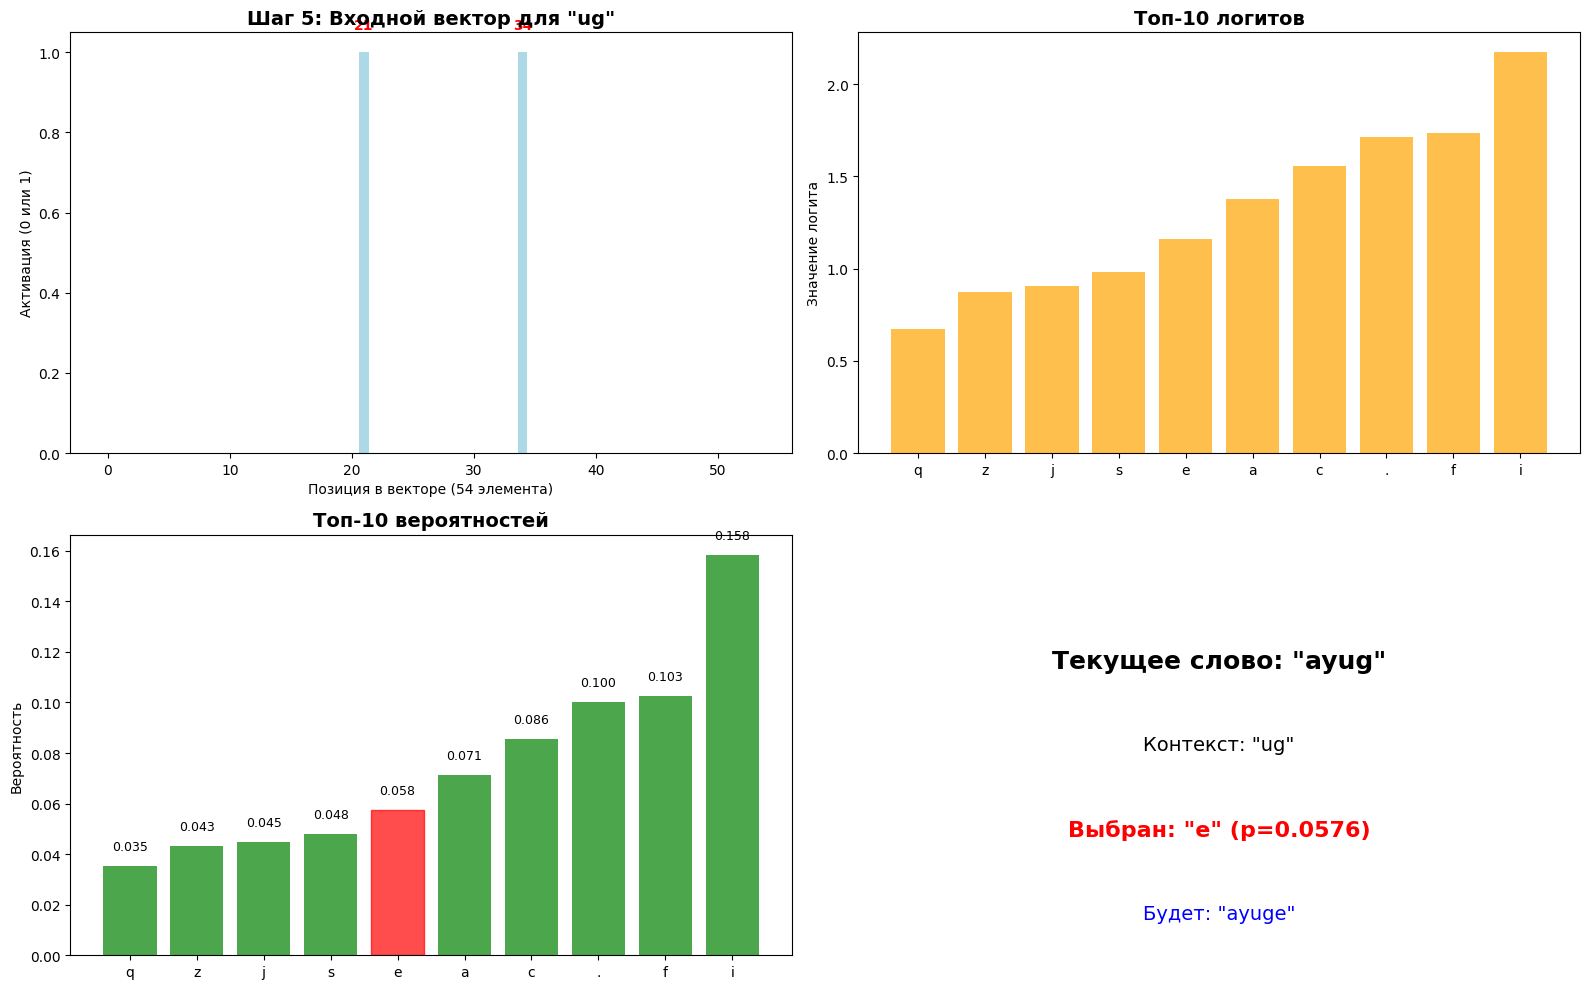


Шаг 5:
  Контекст: 'ug'
  Выбран: 'e' (вероятность: 0.0576)
  Слово: 'ayug' → 'ayuge'


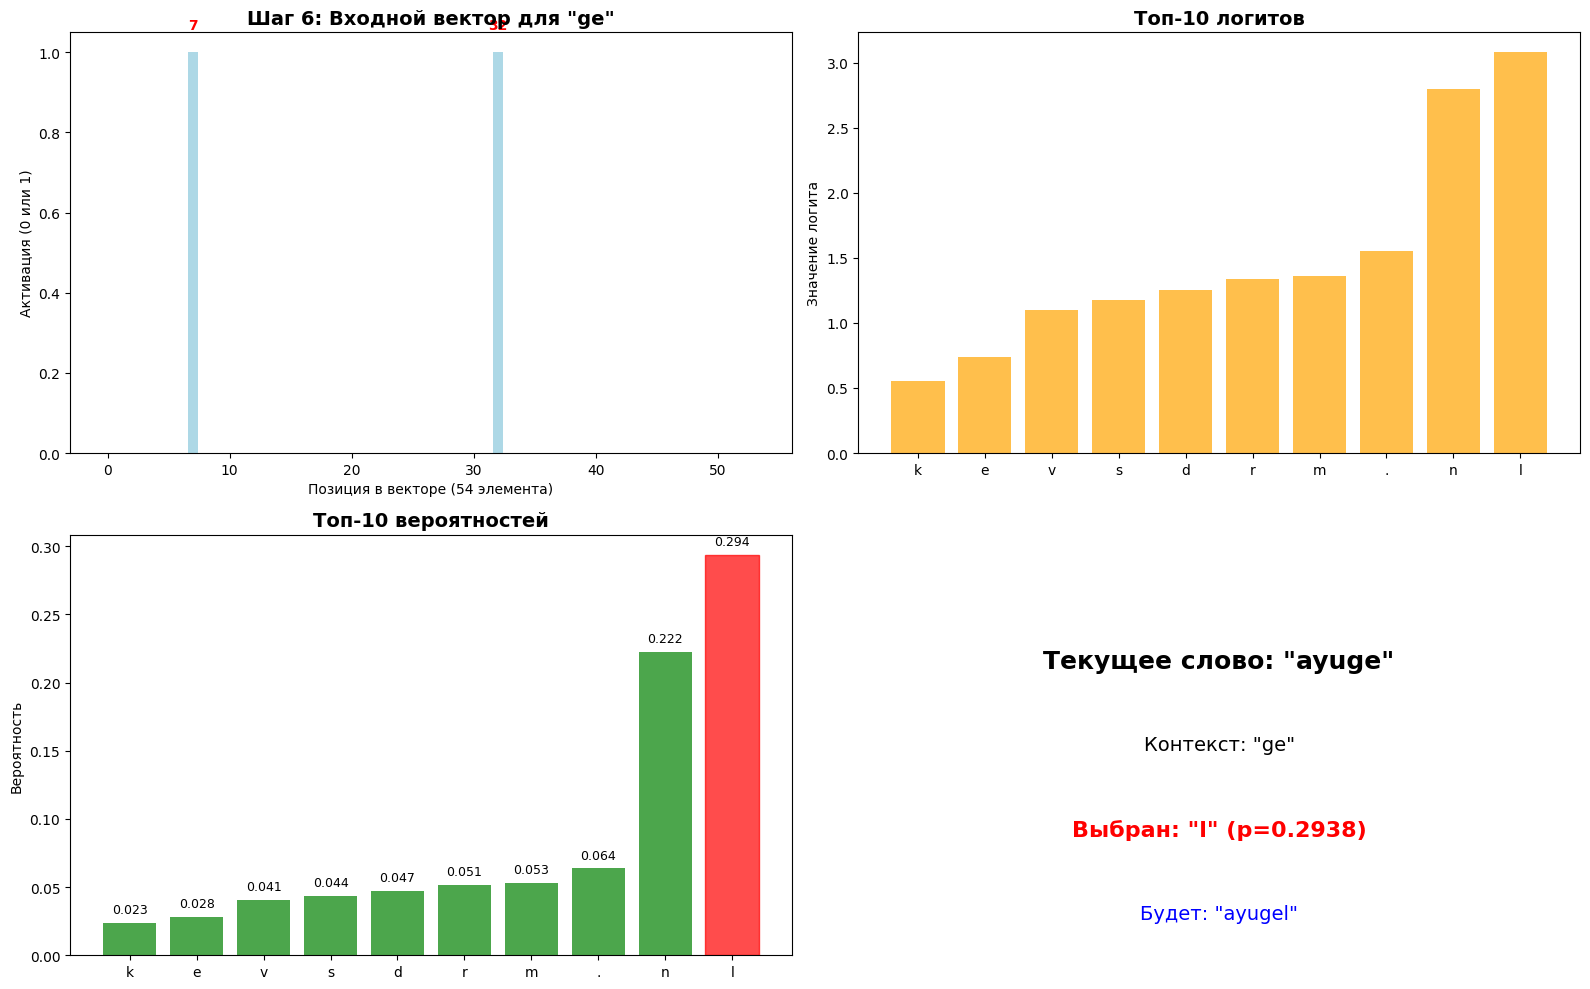


Шаг 6:
  Контекст: 'ge'
  Выбран: 'l' (вероятность: 0.2938)
  Слово: 'ayuge' → 'ayugel'


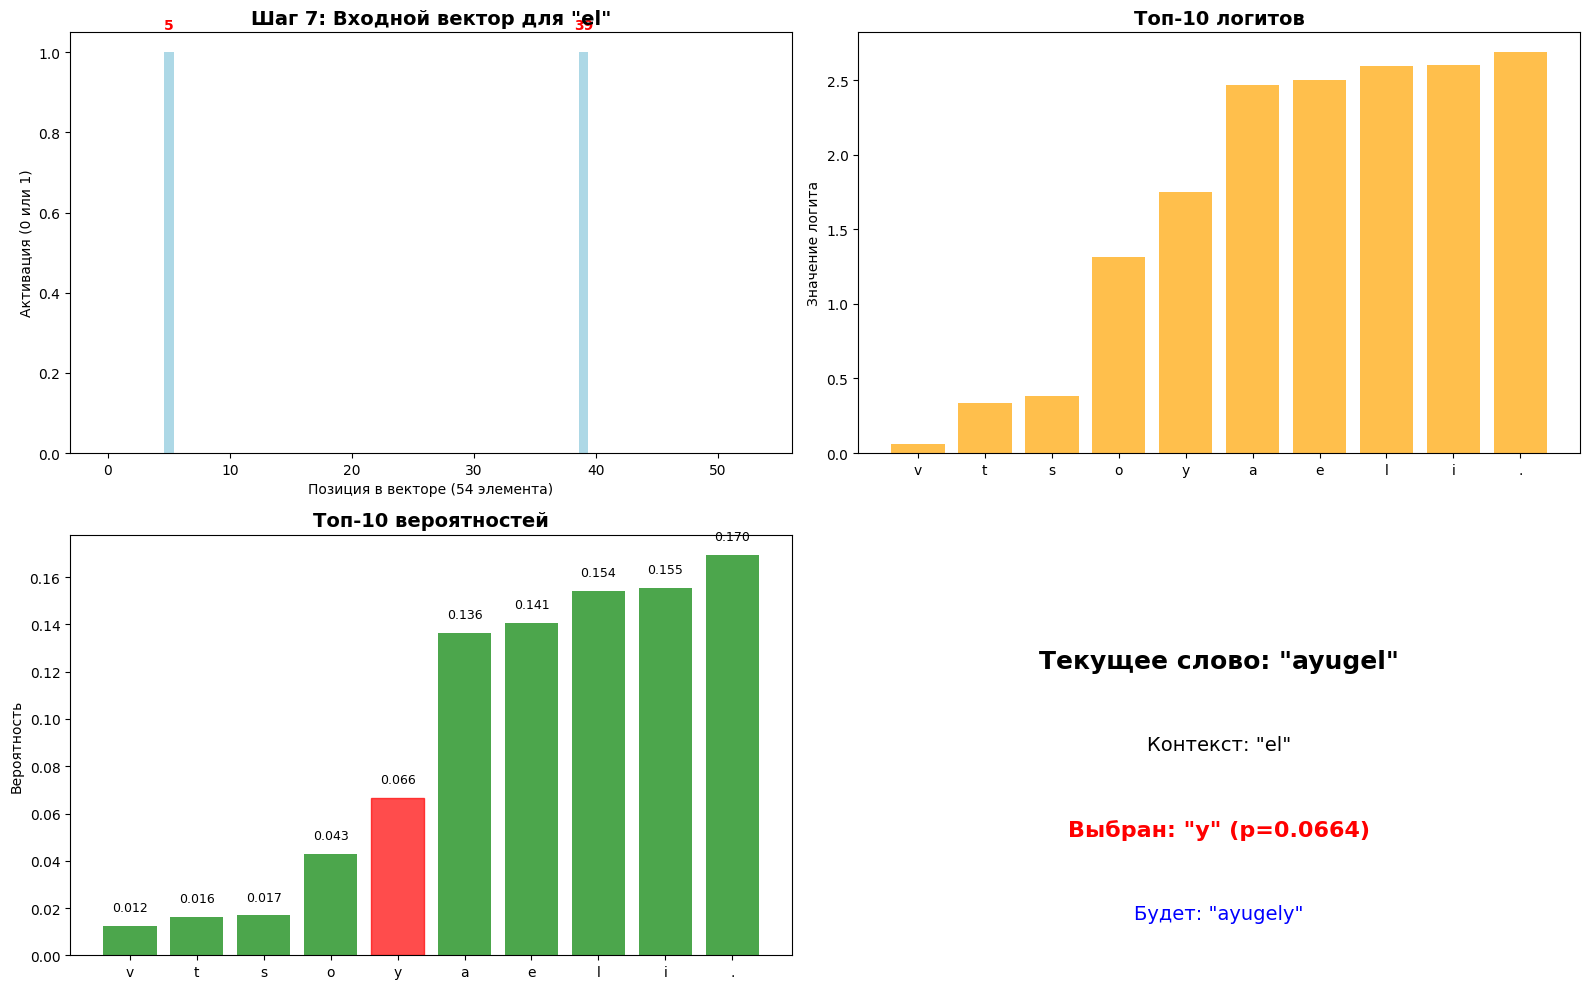


Шаг 7:
  Контекст: 'el'
  Выбран: 'y' (вероятность: 0.0664)
  Слово: 'ayugel' → 'ayugely'


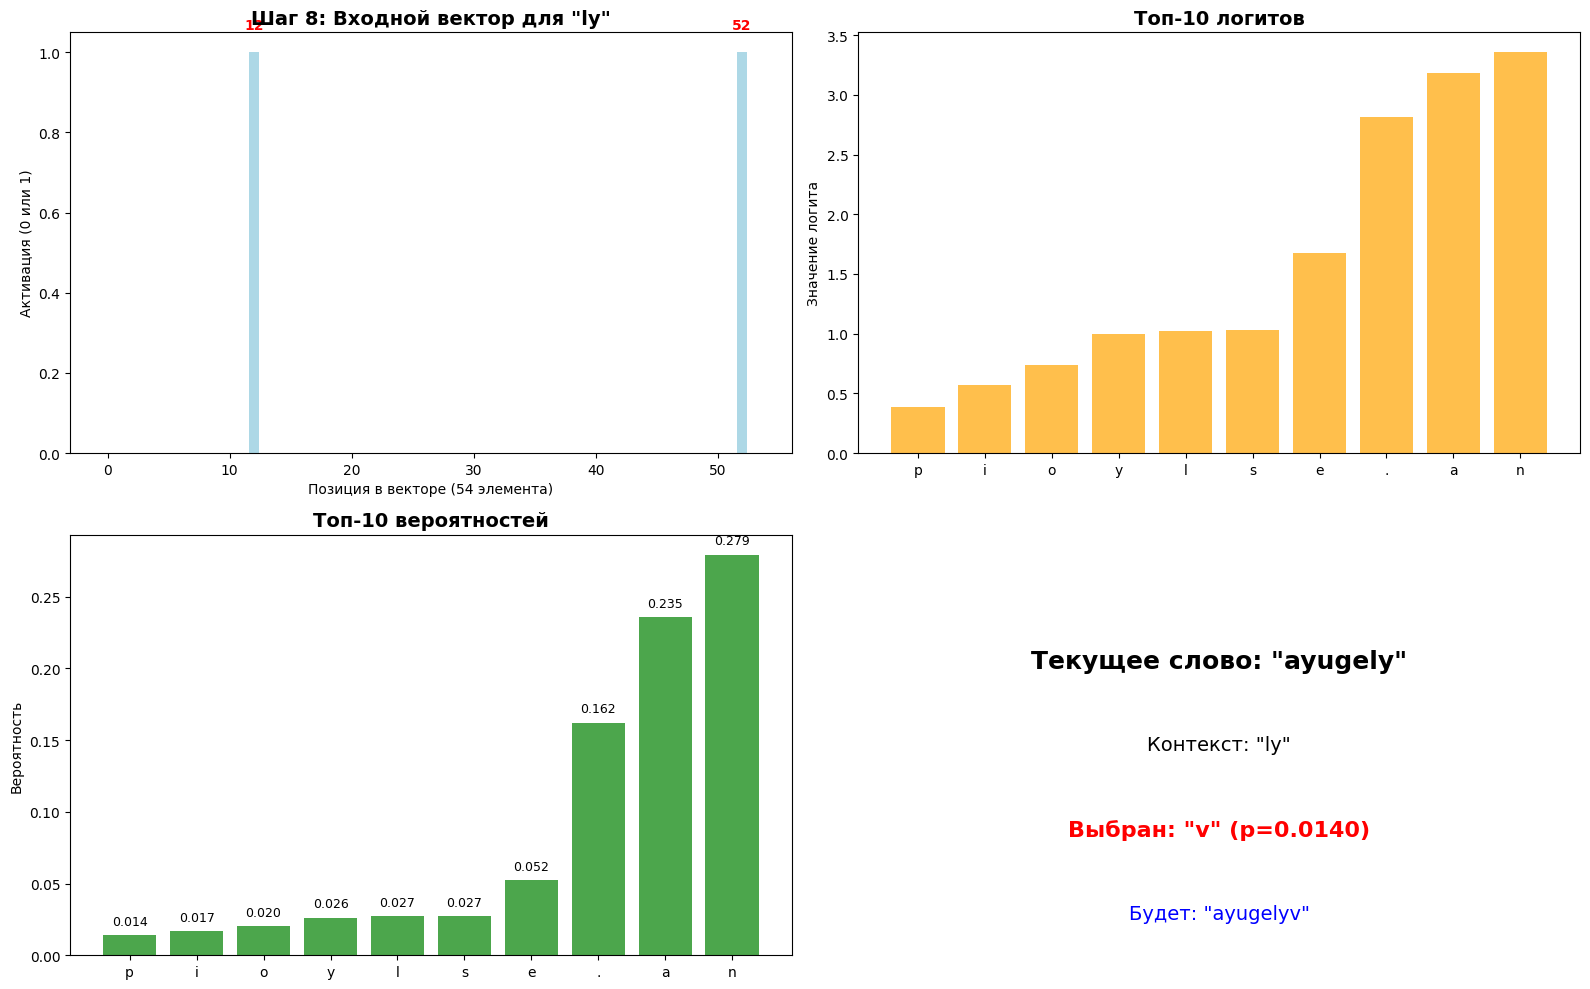


Шаг 8:
  Контекст: 'ly'
  Выбран: 'v' (вероятность: 0.0140)
  Слово: 'ayugely' → 'ayugelyv'


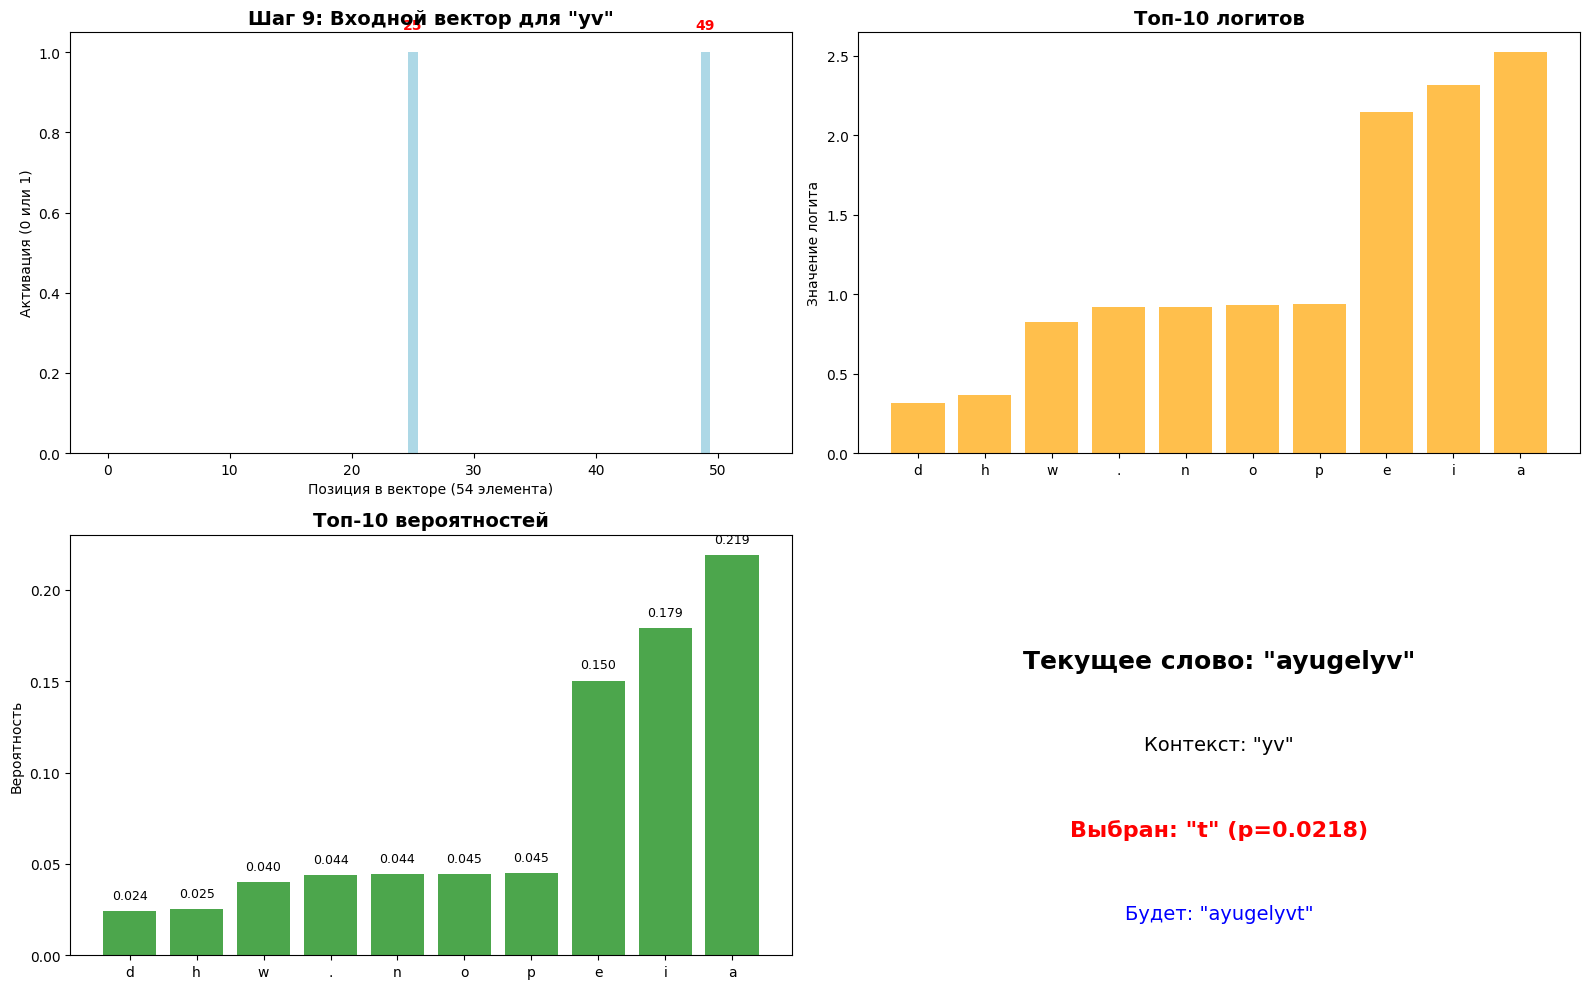


Шаг 9:
  Контекст: 'yv'
  Выбран: 't' (вероятность: 0.0218)
  Слово: 'ayugelyv' → 'ayugelyvt'


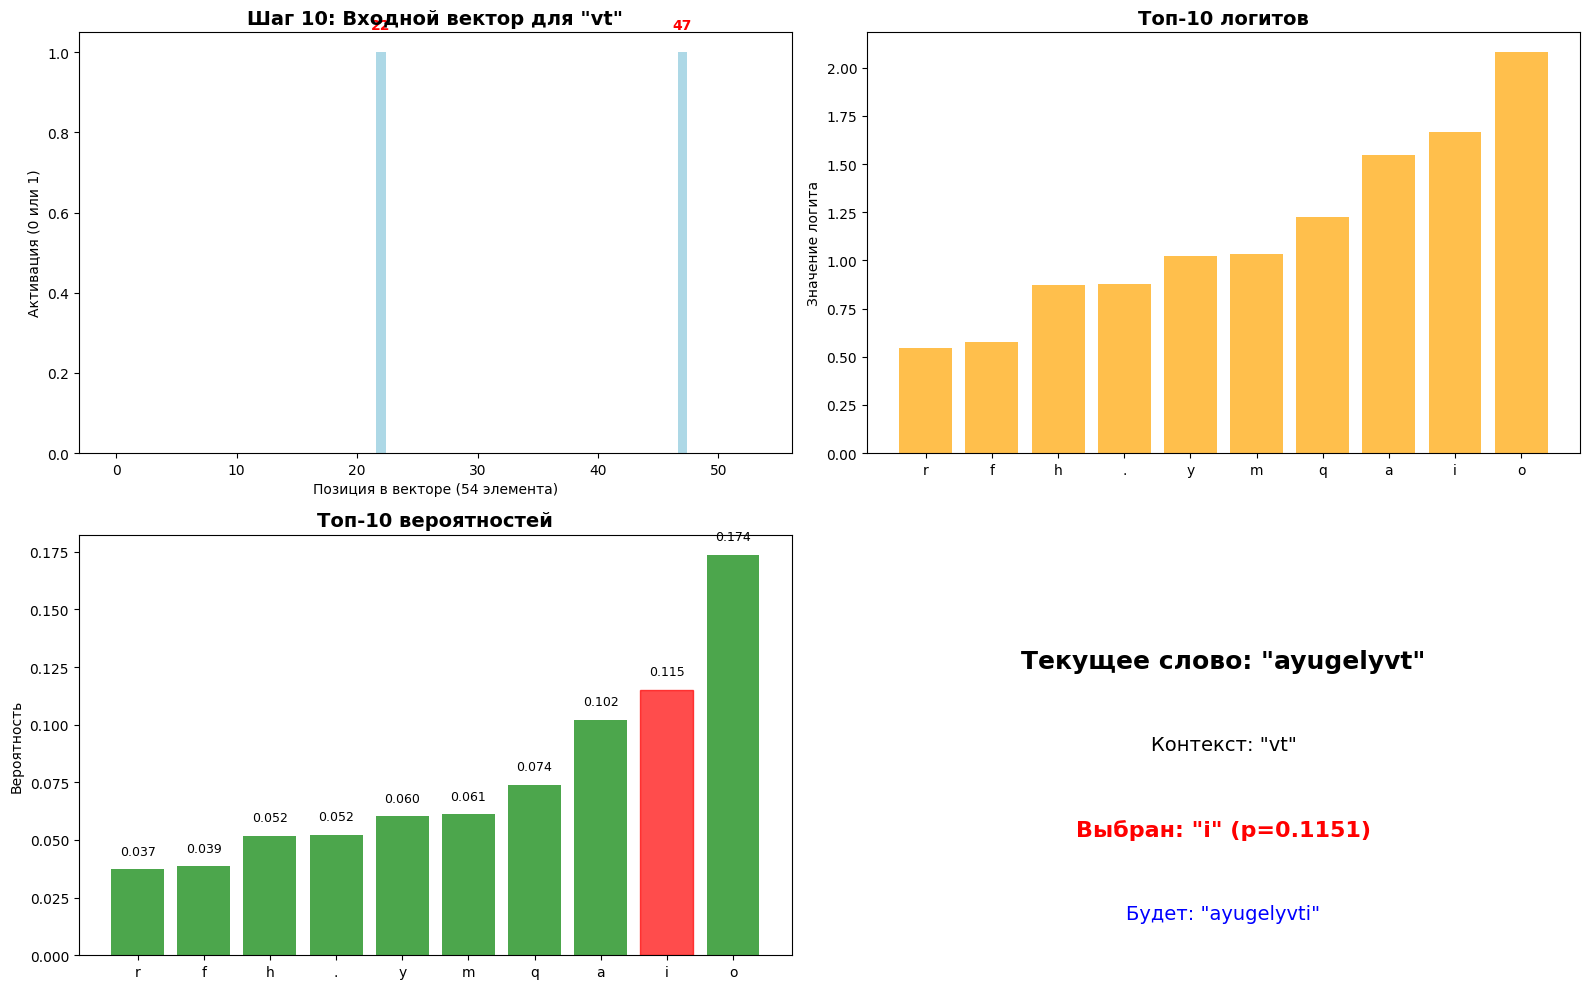


Шаг 10:
  Контекст: 'vt'
  Выбран: 'i' (вероятность: 0.1151)
  Слово: 'ayugelyvt' → 'ayugelyvti'


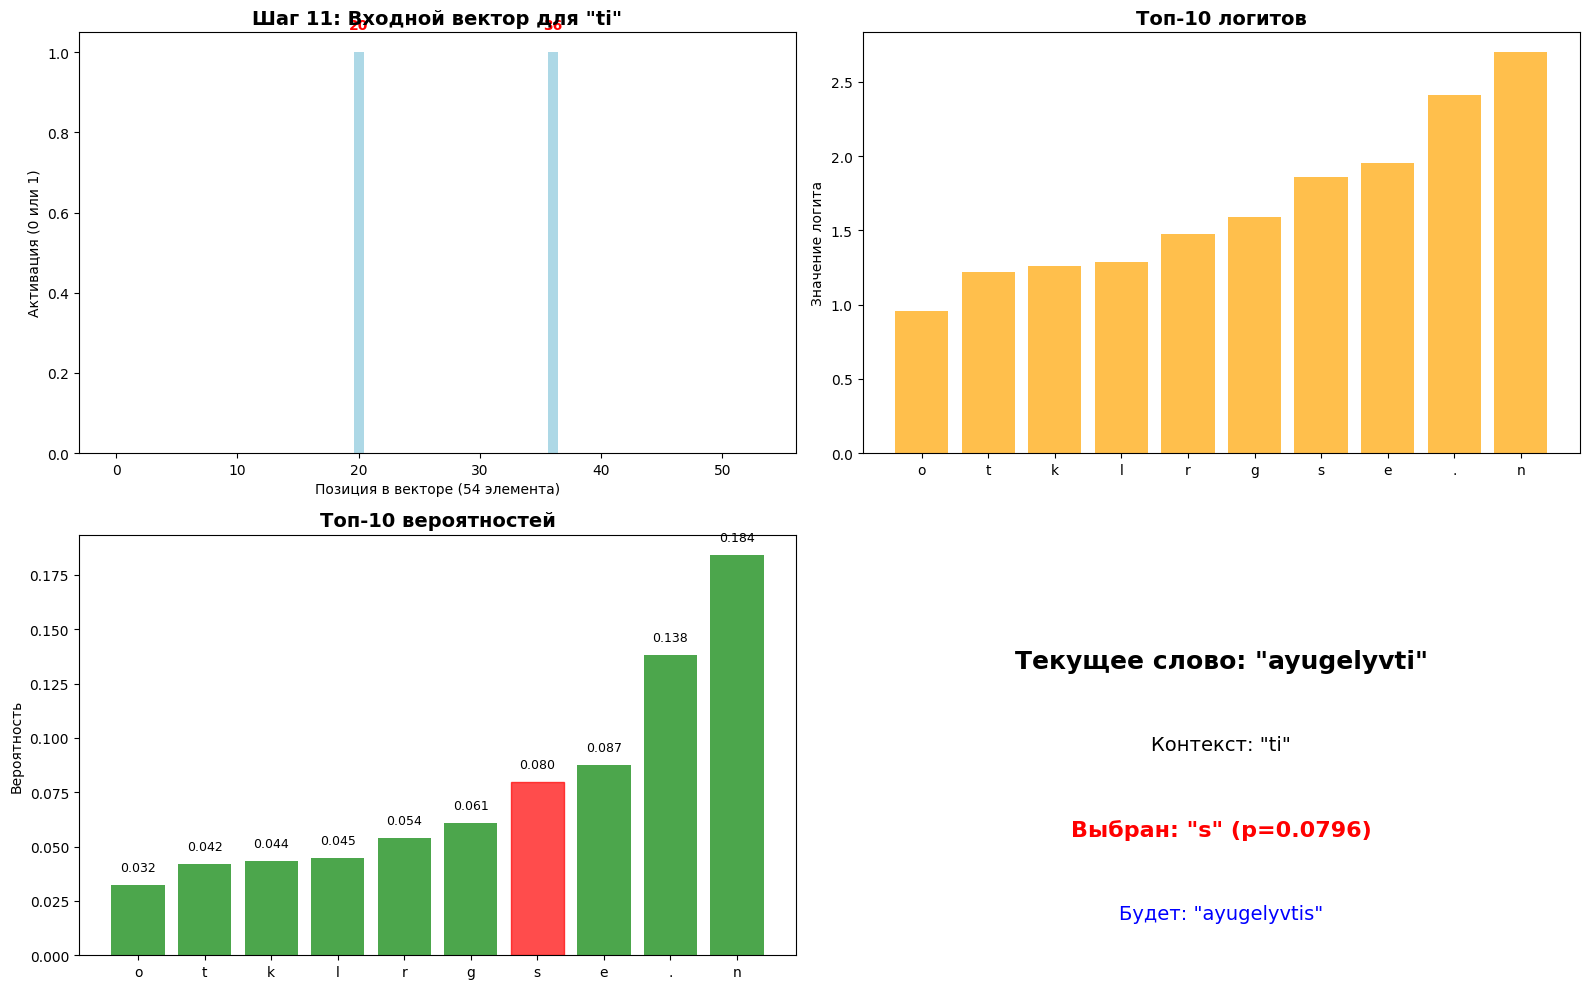


Шаг 11:
  Контекст: 'ti'
  Выбран: 's' (вероятность: 0.0796)
  Слово: 'ayugelyvti' → 'ayugelyvtis'


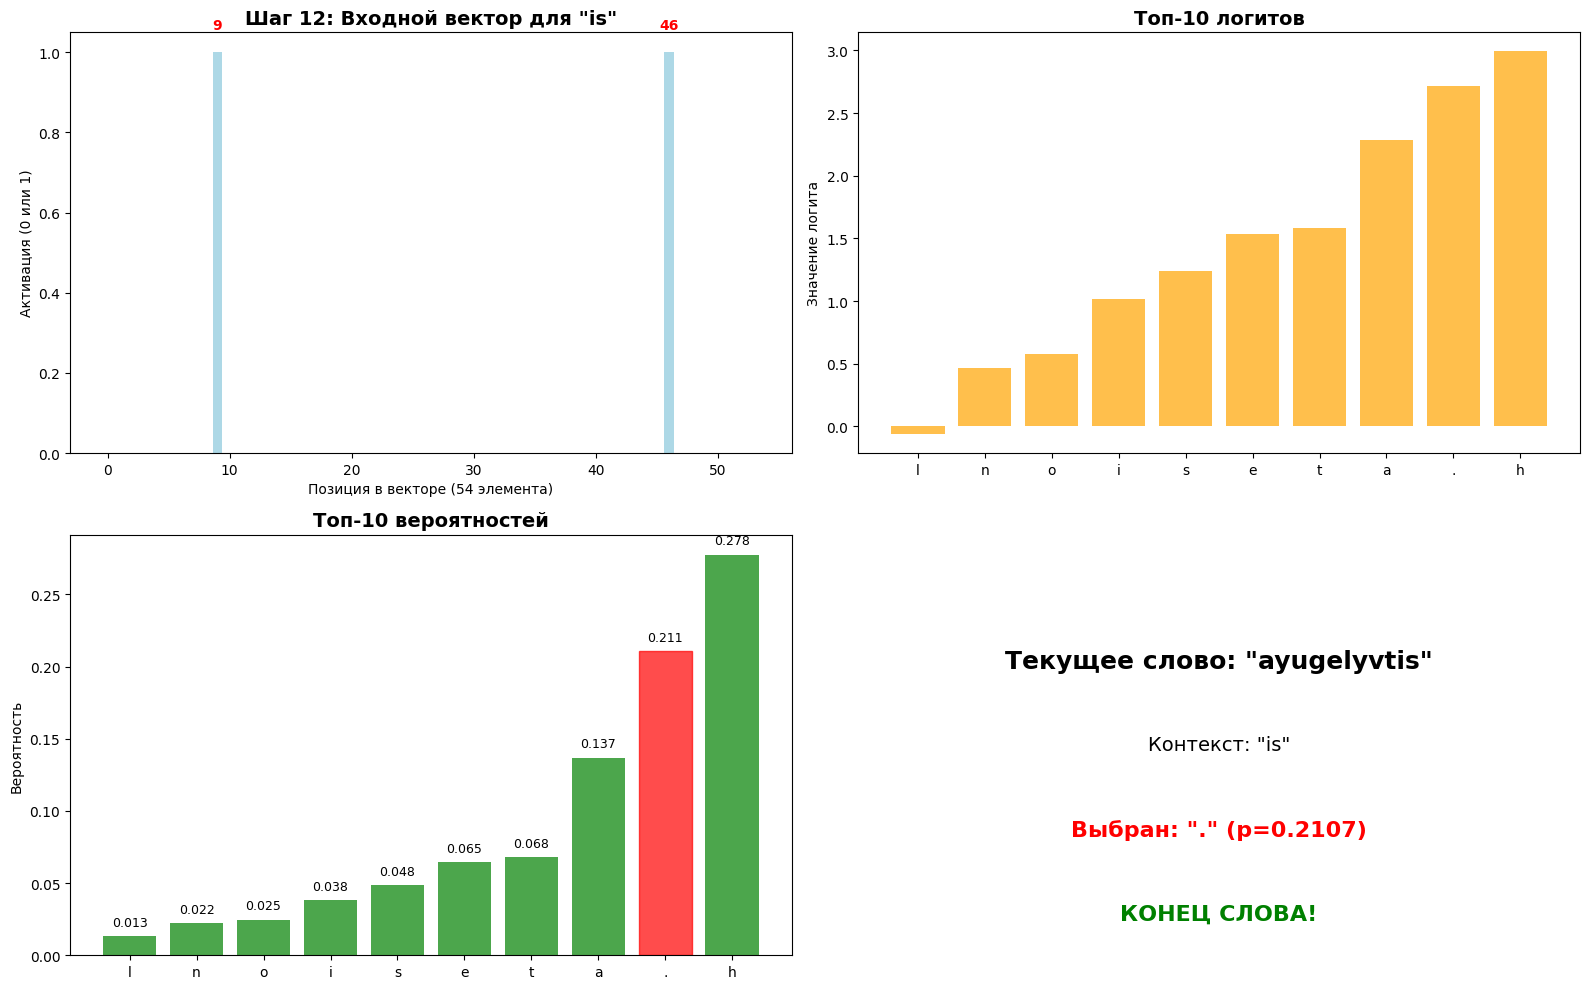


Шаг 12:
  Контекст: 'is'
  Выбран: '.' (вероятность: 0.2107)
  Слово: 'ayugelyvtis' → 'ayugelyvtis'

🎉 Финальное слово: 'ayugelyvtis'


In [101]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, clear_output
import time


def visualize_word_generation(W, stoi, itos, seed=2147483647):
    g = torch.Generator().manual_seed(seed)

    ix1, ix2 = 0, 0  # start with '.', '.'
    generated_word = []
    step = 0

    print("🎬 Генерация слова:")
    print("=" * 60)

    while True:
        step += 1

        # Forward pass
        x1 = F.one_hot(torch.tensor([ix1]), num_classes=27).float()
        x2 = F.one_hot(torch.tensor([ix2]), num_classes=27).float()
        xenc = torch.cat([x1, x2], dim=1).float()
        logits = xenc @ W
        counts = logits.exp()
        probs = counts / counts.sum(1, keepdim=True)

        # Создаем новый график для каждого шага
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))

        # 1. Показать входной контекст
        input_vec = xenc[0].detach().numpy()
        ax1.bar(range(54), input_vec, color='lightblue')
        ax1.set_title(f'Шаг {step}: Входной вектор для "{itos[ix1]}{itos[ix2]}"', fontsize=14, weight='bold')
        ax1.set_ylabel('Активация (0 или 1)')
        ax1.set_xlabel('Позиция в векторе (54 элемента)')

        # Подписываем активные позиции
        active_pos = np.where(input_vec == 1)[0]
        for pos in active_pos:
            ax1.text(pos, 1.05, f'{pos}', ha='center', va='bottom', color='red', weight='bold')

        # 2. Показать топ-10 логитов
        logits_np = logits[0].detach().numpy()
        top_indices = np.argsort(logits_np)[-10:]
        top_logits = logits_np[top_indices]
        top_chars = [itos[i] for i in top_indices]

        bars2 = ax2.bar(range(10), top_logits, color='orange', alpha=0.7)
        ax2.set_title('Топ-10 логитов', fontsize=14, weight='bold')
        ax2.set_ylabel('Значение логита')
        ax2.set_xticks(range(10))
        ax2.set_xticklabels(top_chars)

        # 3. Показать топ-10 вероятности
        probs_np = probs[0].detach().numpy()
        top_prob_indices = np.argsort(probs_np)[-10:]
        top_probs = probs_np[top_prob_indices]
        top_prob_chars = [itos[i] for i in top_prob_indices]

        bars3 = ax3.bar(range(10), top_probs, color='green', alpha=0.7)
        ax3.set_title('Топ-10 вероятностей', fontsize=14, weight='bold')
        ax3.set_ylabel('Вероятность')
        ax3.set_xticks(range(10))
        ax3.set_xticklabels(top_prob_chars)

        # Добавляем значения на столбцы
        for i, (bar, prob) in enumerate(zip(bars3, top_probs)):
            ax3.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.005,
                     f'{prob:.3f}', ha='center', va='bottom', fontsize=9)

        # Сэмплирование
        ix3 = torch.multinomial(probs[0], num_samples=1, replacement=True, generator=g).item()
        chosen_char = itos[ix3]

        # Подсвечиваем выбранный символ если он в топ-10
        if ix3 in top_prob_indices:
            chosen_pos = np.where(top_prob_indices == ix3)[0][0]
            bars3[chosen_pos].set_color('red')

        # 4. Показать текущее состояние
        current_word = ''.join(generated_word)
        if chosen_char != '.':
            preview_word = current_word + chosen_char
        else:
            preview_word = current_word

        ax4.text(0.5, 0.7, f'Текущее слово: "{current_word}"', ha='center', va='center',
                 fontsize=18, weight='bold', transform=ax4.transAxes)
        ax4.text(0.5, 0.5, f'Контекст: "{itos[ix1]}{itos[ix2]}"', ha='center', va='center',
                 fontsize=14, transform=ax4.transAxes)
        ax4.text(0.5, 0.3, f'Выбран: "{chosen_char}" (p={probs_np[ix3]:.4f})',
                 ha='center', va='center', fontsize=16, color='red', weight='bold', transform=ax4.transAxes)

        if chosen_char != '.':
            ax4.text(0.5, 0.1, f'Будет: "{preview_word}"', ha='center', va='center',
                     fontsize=14, color='blue', transform=ax4.transAxes)
        else:
            ax4.text(0.5, 0.1, f'КОНЕЦ СЛОВА!', ha='center', va='center',
                     fontsize=16, color='green', weight='bold', transform=ax4.transAxes)

        ax4.set_xlim(0, 1)
        ax4.set_ylim(0, 1)
        ax4.axis('off')

        plt.tight_layout()
        plt.show()

        # Печатаем информацию
        print(f"\nШаг {step}:")
        print(f"  Контекст: '{itos[ix1]}{itos[ix2]}'")
        print(f"  Выбран: '{chosen_char}' (вероятность: {probs_np[ix3]:.4f})")
        print(f"  Слово: '{current_word}' → '{preview_word}'")

        if ix3 == 0:  # end of word
            print(f"\n🎉 Финальное слово: '{current_word}'")
            break

        generated_word.append(chosen_char)
        ix1, ix2 = ix2, ix3

        if len(generated_word) > 15:  # защита от бесконечных слов
            print("⚠️ Слишком длинное слово, прерываем...")
            break

        time.sleep(2)  # пауза между шагами

    return ''.join(generated_word)


# Запуск визуализации
generated = visualize_word_generation(W, stoi, itos, seed=42)